# L2 penalised logistic regression model

## Assessing the predictive ability of a Scikit learn logisitc regression model with an L2 penalty 

Using a training and testing split of the DCD and DBD datasets to fit and assess the predictive ability of a logistic regression model fit using an L2 penalty

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as mets
%matplotlib inline

# Function to print confusion matrix, balanced accuracy and accuracy for a set of actual and predicted labels
def show_metrics(actual,predict):
    """ Prints the confusion matrix, balanced accuracy and accuracy given datasets of actual and predicted labels
    
    Arguments:
        actual - Dataset of actual labels
        predict - Dataset of predicted labels
     """
    cm = mets.confusion_matrix(actual, predict)
    
    print("********* MODEL METRIC REPORT *********\n\nConfusion matrix:\n")

    print("TN  FN\nFP  TP\n") #this is a reminder of what each part of the confusion matrix means e.g. TP = True Positive
    
    # print the confusion matrix
    print(str(int(cm[0,0])) + "    " + str(int(cm[0,1])))
    print(str(int(cm[1,0])) + "    " + str(int(cm[1,1])) + "\n") 

    # classification report for DBD model
    print("Classification report:\n")
    print(mets.classification_report(actual, predict))

    print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(actual, predict),2)))

    print("Accuracy: " + str(round(mets.accuracy_score(actual, predict),2)))
    
    # Predicted vs actual consent rates
    cons_rate = int(100 * len(actual[actual==2]) / len(actual) )
    print("\nActual consent rate: " + str(cons_rate))
    
    pred_rate = int(100 * len(predict[predict==2]) / len(predict) )
    print("Predicted consent rate: " + str(pred_rate))

In [8]:
# Read in datasets 
dbd_model_data = pd.read_csv("Data/dbd_model_data.csv")
dcd_model_data = pd.read_csv("Data/dcd_model_data.csv")

# Columns used to create DBD model
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "adult","FAMILY_CONSENT"]

dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cols[:-1],drop_first=True)

dbd_features = dbd_model_data2.drop("FAMILY_CONSENT",axis=1)
dbd_consents = dbd_model_data2["FAMILY_CONSENT"]

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "adult","cod_neuro","FAMILY_CONSENT"]

dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cols[:-1],drop_first=True)

dcd_features = dcd_model_data2.drop("FAMILY_CONSENT",axis=1)
dcd_consents = dcd_model_data2["FAMILY_CONSENT"]

# creating a train and testing dataset for DBD and DCD approaches
DBD_X_train, DBD_X_test, DBD_y_train, DBD_y_test = train_test_split(dbd_features,dbd_consents, test_size=0.33, random_state=10)

DCD_X_train, DCD_X_test, DCD_y_train, DCD_y_test = train_test_split(dcd_features,dcd_consents, test_size=0.33, random_state=10)

In [9]:
# fitting logistic regression to training data with L2 penatly
LR_model = LogisticRegression(penalty='l2')

In [10]:
DBD_LR = LR_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_LR.predict(DBD_X_test)
DBD_prob= DBD_LR.predict_proba(DBD_X_test)

show_metrics(DBD_y_test, DBD_preds)

********* MODEL METRIC REPORT *********

Confusion matrix:

TN  FN
FP  TP

251    367
120    1262

Classification report:

              precision    recall  f1-score   support

         1.0       0.68      0.41      0.51       618
         2.0       0.77      0.91      0.84      1382

    accuracy                           0.76      2000
   macro avg       0.73      0.66      0.67      2000
weighted avg       0.74      0.76      0.74      2000

Balanced accuracy: 0.66
Accuracy: 0.76

Actual consent rate: 69
Predicted consent rate: 81


In [12]:
DCD_LR = LR_model.fit(DCD_X_train,DCD_y_train)

DCD_preds = DCD_LR.predict(DCD_X_test)
DCD_prob= DCD_LR.predict_proba(DCD_X_test)

show_metrics(DCD_y_test, DCD_preds)

********* MODEL METRIC REPORT *********

Confusion matrix:

TN  FN
FP  TP

773    466
395    1470

Classification report:

              precision    recall  f1-score   support

         1.0       0.66      0.62      0.64      1239
         2.0       0.76      0.79      0.77      1865

    accuracy                           0.72      3104
   macro avg       0.71      0.71      0.71      3104
weighted avg       0.72      0.72      0.72      3104

Balanced accuracy: 0.71
Accuracy: 0.72

Actual consent rate: 60
Predicted consent rate: 62


Text(0.5, 1.0, 'DBD and DCD ROC curves')

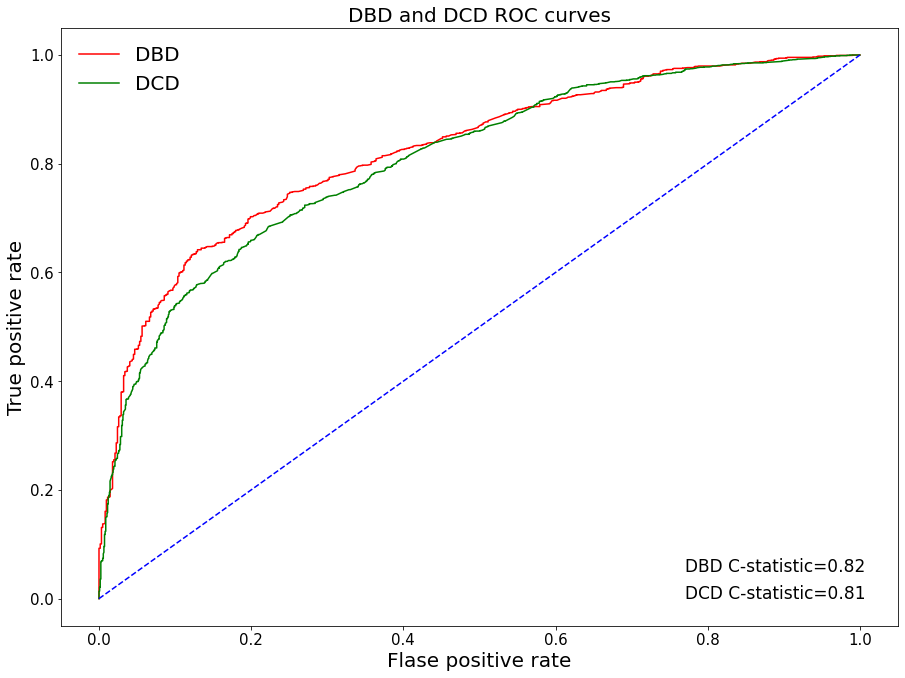

In [13]:
# ROC curve for both models
dbd_roc = mets.roc_curve(DBD_y_test, DBD_prob[:,1], pos_label=2)
dbd_auc = mets.roc_auc_score(DBD_y_test, DBD_prob[:,1], labels=[1,2])
dbd_c_stat = "DBD C-statistic=" + str(round(dbd_auc,2))

dcd_roc = mets.roc_curve(DCD_y_test, DCD_prob[:,1], pos_label=2)
dcd_auc = mets.roc_auc_score(DCD_y_test, DCD_prob[:,1], labels=[1,2])
dcd_c_stat = "DCD C-statistic=" + str(round(dcd_auc,2))


fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(dbd_roc[0],dbd_roc[1],"r")
ax.plot(dcd_roc[0],dcd_roc[1],"g")
ax.plot([0,1],[0,1],"--b")
ax.tick_params(axis="y",labelsize=15)
ax.tick_params(axis="x",labelsize=15)
ax.legend(["DBD","DCD"],loc="best",fontsize=20,frameon=False)

ax.text(0.77,0.05,dbd_c_stat, fontdict={'size':17, 'color':'black'})
ax.text(0.77,0,dcd_c_stat, fontdict={'size':17, 'color':'black'})

plt.xlabel("Flase positive rate",size=20)
plt.ylabel("True positive rate",size=20)
plt.title("DBD and DCD ROC curves",size=20)

## Tuning L2 regularisation parameter

Text(0.5, 1.0, 'Effect of regularisation strength on DBD model metrics')

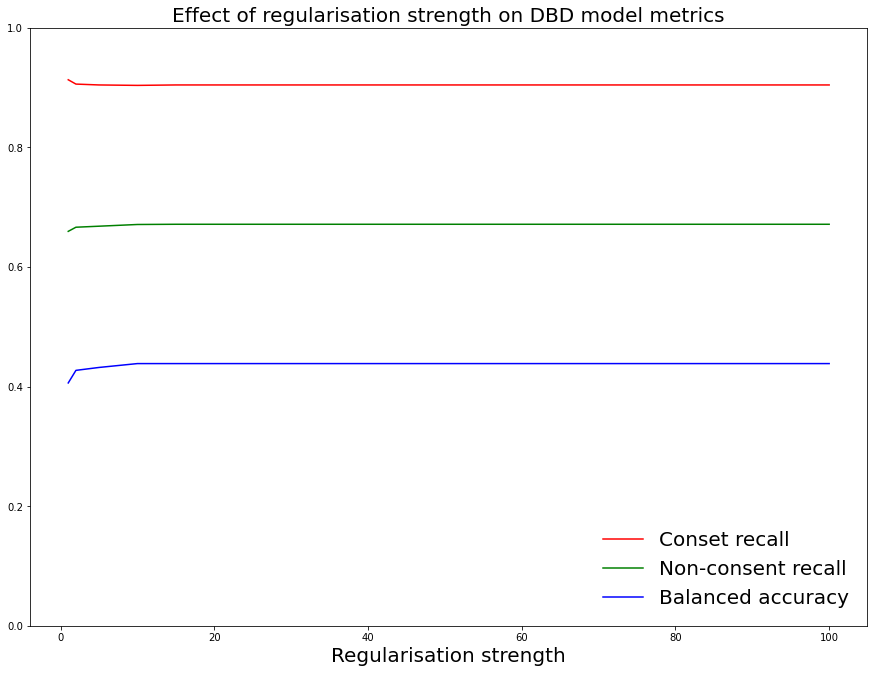

In [44]:
recall_cons = []
recall_refs = []
bas = []
cs = [1,2,5,10,15,20,30,40,100]

for c in cs:
    LR_model = LogisticRegression(penalty='l2',C=c)
    DBD_LR = LR_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_LR.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))
    
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(cs,recall_cons,"r")
ax.plot(cs,bas,"g")
ax.plot(cs,recall_refs,"b")
plt.xlabel("Regularisation strength",size=20)
ax.legend(["Conset recall","Non-consent recall","Balanced accuracy"],loc=4,fontsize=20,frameon=False)
ax.set_ylim([0,1])

plt.title("Effect of regularisation strength on DBD model metrics",size=20)

Text(0.5, 1.0, 'Effect of regularisation strength on DCD model metrics')

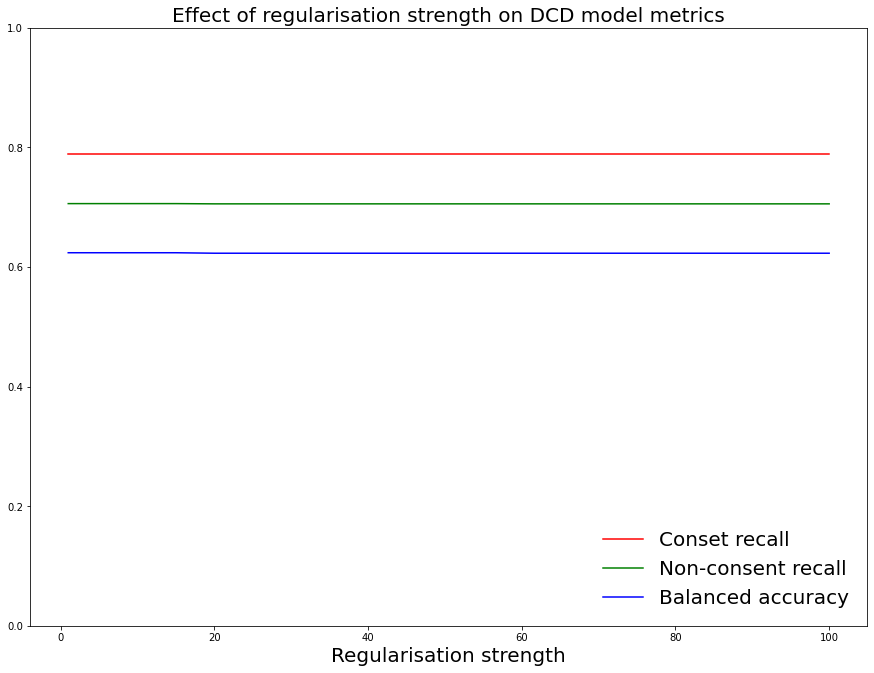

In [45]:
recall_cons = []
recall_refs = []
bas = []
cs = [1,2,5,10,15,20,30,40,100]

for c in cs:
    LR_model = LogisticRegression(penalty='l2',C=c)
    DCD_LR = LR_model.fit(DCD_X_train,DCD_y_train)
    DCD_preds = DCD_LR.predict(DCD_X_test)
    recall_cons.append(mets.recall_score(DCD_y_test,DCD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DCD_y_test,DCD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DCD_y_test,DCD_preds))
    
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(cs,recall_cons,"r")
ax.plot(cs,bas,"g")
ax.plot(cs,recall_refs,"b")
plt.xlabel("Regularisation strength",size=20)
ax.legend(["Conset recall","Non-consent recall","Balanced accuracy"],loc=4,fontsize=20,frameon=False)
ax.set_ylim([0,1])
plt.title("Effect of regularisation strength on DCD model metrics",size=20)